In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import directory_functions as dirfuncs
import gather_middleware_statistics as gmws
import cut_away_warmup_cooldown as cut
from cycler import cycler
np.set_printoptions(threshold=np.nan)

In [2]:
# What should be the granularity of the memtier response time interpolation?
granularity = 0.1

In [3]:
# Extract GET histogram from single memtier logfile
def parse_line(line):
    split = line.split()
    return (split[1], split[2])
def extract_GET_histogram(client_logfile_path):
    with open(client_logfile_path, "r") as logfile:
        return [parse_line(line)for line in logfile if line.startswith("GET")]

In [4]:
def extract_GET_throughput(client_logfile_path):
    with open(client_logfile_path, "r") as logfile:
        for line in logfile:
            if line.startswith("Gets"):
                split_line = line.split()
                return float(split_line[1])

In [5]:
def interpolate_histogram(hist, granularity):
    rowcount = hist.shape[0]
    desired_steps = np.arange(start=hist[0, 0], stop=hist[rowcount-1, 0], step=granularity)
    return desired_steps, np.interp(desired_steps, hist[:,0], hist[:,1])

In [9]:
def calculate_numrequests(interpolated, xput, granularity):
    interpolated = np.vstack(interpolated).transpose()
    sorted = interpolated[interpolated[:,0].argsort()]

    shifted = np.hstack([sorted[:-1,:], sorted[1:,:]])
    shifted_frame = pd.DataFrame(data=shifted, columns=['responsetime_unshifted', 'percentile_unshifted', 'responsetime', 'percentile'])
    shifted_frame['num_requests'] = shifted_frame['percentile'] * xput / 100
    shifted_frame['num_requests_unshifted'] = shifted_frame['percentile_unshifted'] * xput / 100
    shifted_frame['requests'] = (shifted_frame['num_requests'] - shifted_frame['num_requests_unshifted'])

    return shifted_frame.loc[:, ['responsetime', 'percentile', 'requests']]

In [7]:
def combine_multiple_histograms(histogram_arrays, throughputs, granularity):
    interpolated = [interpolate_histogram(hist, granularity) for hist in histogram_arrays]
    interpolated_with_numrequests = [calculate_numrequests(interp, xput, granularity) for interp, xput in zip(interpolated, throughputs)]
    return pd.concat(interpolated_with_numrequests).groupby('responsetime').agg({'requests': 'sum'}).reset_index()

In [10]:
# Extracting histograms for Sharded
exp5_1_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912"
experiments = ["sharded_1multiget", "sharded_3multiget", "sharded_6multiget", "sharded_9multiget"]
client_logfiles = ["client_01_0.log", "client_01_1.log", "client_02_0.log", "client_02_1.log", "client_03_0.log", "client_03_1.log"]
reps = 3
exp_filepaths = [[os.path.join(exp5_1_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles] for experiment in experiments]
exp_histograms = [[np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths] for filepaths in exp_filepaths]
exp_throughputs = [[extract_GET_throughput(filepath) for filepath in filepaths] for filepaths in exp_filepaths]
hist_data_sharded = [combine_multiple_histograms(histograms, throughputs, granularity) for histograms, throughputs in zip(exp_histograms, exp_throughputs)]


In [12]:
# Extracting histograms for Non-Sharded
exp5_2_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_2_multigets_nonsharded_2017-11-24_092308"
experiments = ["nonsharded_1multiget", "nonsharded_3multiget", "nonsharded_6multiget", "nonsharded_9multiget"]
client_logfiles = ["client_01_0.log", "client_01_1.log", "client_02_0.log", "client_02_1.log", "client_03_0.log", "client_03_1.log"]
reps = 3
exp_filepaths = [[os.path.join(exp5_2_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles] for experiment in experiments]
exp_histograms = [[np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths] for filepaths in exp_filepaths]
exp_throughputs = [[extract_GET_throughput(filepath) for filepath in filepaths] for filepaths in exp_filepaths]
hist_data_nonsharded = [combine_multiple_histograms(histograms, throughputs, granularity) for histograms, throughputs in zip(exp_histograms, exp_throughputs)]


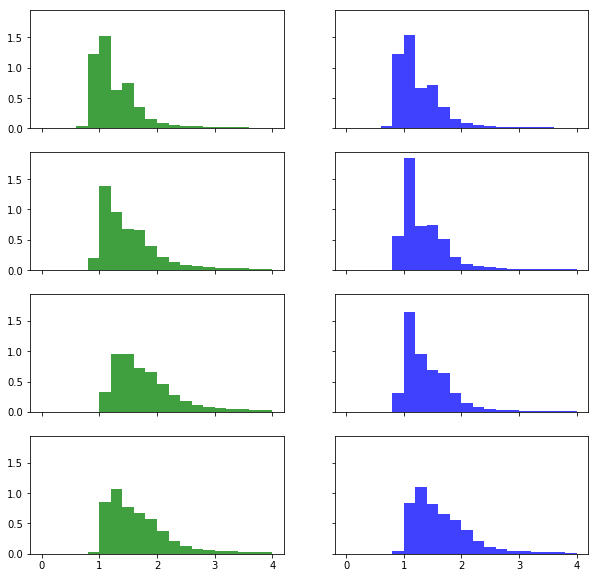

In [13]:
# Plot total histograms
xrng = [0, 4]
buckets = 20
num_subplots = len(hist_data_sharded)
fig, axes = plt.subplots(num_subplots, 2, sharey=True, sharex=True, figsize=(10,10))
for i in range(0, num_subplots):
    axes[i, 0].hist(hist_data_sharded[i]['responsetime'], buckets, weights=hist_data_sharded[i]['requests'], range=xrng, normed=1, facecolor='green', alpha=0.75)
    axes[i, 1].hist(hist_data_nonsharded[i]['responsetime'], buckets, weights=hist_data_nonsharded[i]['requests'], range=xrng, normed=1, facecolor='blue', alpha=0.75)
    
#axes.set_xlim(range)
plt.show()

In [28]:
# Percentile plot
multigets = [1, 3, 6, 9]
desired_percentiles = [.25, .50, .75, .90, .99]

# Taken from http://yiqun-dai.blogspot.ch/2017/03/weighted-percentile-in-python-pandas.html
def wquantile(x,q):           
    xsort = x.sort_values(x.columns[0])
    xsort['index'] = range(len(x))
    p = q * x[x.columns[1]].sum()
    pop = float(xsort[xsort.columns[1]][xsort['index']==0])
    i = 0
    while pop < p:
        pop = pop + float(xsort[xsort.columns[1]][xsort['index']==i+1])
        i = i + 1
    return xsort[xsort.columns[0]][xsort['index']==i]

def extract_percentiles(hist_data, multigets, percentiles):
    percentile_list = []
    for i in range(0,4):
        data = hist_data[i]
        percentile_list.extend([(multigets[i], perc, wquantile(data, perc)) for perc in percentiles])
    return pd.DataFrame(data=percentile_list, columns=['multigets', 'percentile', 'responsetime'])

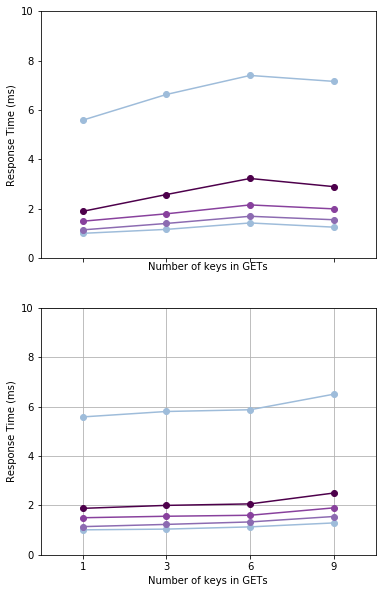

In [31]:
sharded_plot_percentiles = extract_percentiles(hist_data_sharded, multigets, desired_percentiles)
nonsharded_plot_percentiles = extract_percentiles(hist_data_nonsharded, multigets, desired_percentiles)

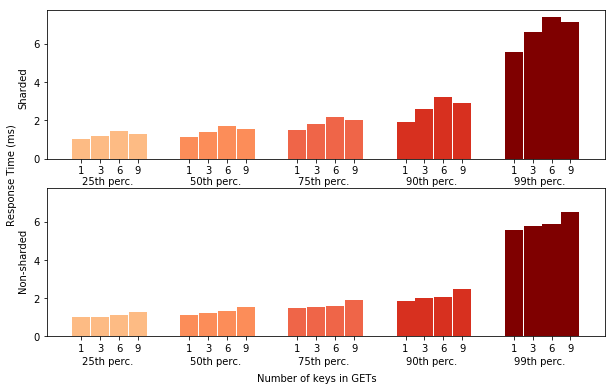

In [52]:
width=0.1
gap = 0.6
bargap=0.005
x = np.concatenate([np.arange(start=1+(i*gap), stop=1+(i*gap)+4*(width+bargap), step=(width+bargap)) for i in range(0, 5)])
#for i in range(0,5):
#    print(x[(4*i):(4*i)+4])
def plot_percentiles_bar(ax, data):
    color_cycler = cycler('color', ['#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#7f0000'])
    ax.set_prop_cycle(color_cycler)
    for i, (key, grp) in enumerate(data.groupby(['percentile'])):
        ax.bar(x[(4*i):(4*i)+4], grp['responsetime'], width=width)
        #ax.set_ylim([0,10])
        #ax.set_xlim([0.5,4.5])
        ax.set_xticks(x)
        #ax.set_xticklabels(grp['multigets'])
        ax.set_xticklabels(('1', '3', '6', '9', '1', '3', '6', '9', '1', '3', '6', '9', '1', '3', '6', '9', '1', '3', '6', '9'))


fig, axes = plt.subplots(2, sharex=False, sharey=True, figsize=(10, 6))

plot_percentiles_bar(axes[0], sharded_plot_percentiles)
plot_percentiles_bar(axes[1], nonsharded_plot_percentiles)

fig.text(0.5, 0.02, 'Number of keys in GETs', ha='center')
fig.text(0.07, 0.5, 'Response Time (ms)', va='center', rotation='vertical')
fig.text(0.085, 0.7, 'Sharded', va='center', rotation='vertical')
fig.text(0.085, 0.3, 'Non-sharded', va='center', rotation='vertical')
fig.text(0.21, 0.06, '25th perc.', ha='center')
fig.text(0.36, 0.06, '50th perc.', ha='center')
fig.text(0.51, 0.06, '75th perc.', ha='center')
fig.text(0.66, 0.06, '90th perc.', ha='center')
fig.text(0.81, 0.06, '99th perc.', ha='center')
fig.text(0.21, 0.477, '25th perc.', ha='center')
fig.text(0.36, 0.477, '50th perc.', ha='center')
fig.text(0.51, 0.477, '75th perc.', ha='center')
fig.text(0.66, 0.477, '90th perc.', ha='center')
fig.text(0.81, 0.477, '99th perc.', ha='center')
plt.show()
fig.savefig("./graphs/exp5/responsetime_percentiles.png", dpi=300)

In [81]:
# Get response times from MW for 6 multigets
def gather_requests(exp_dir, reps, middlewares):
    all_reps = []
    for rep in reps:

        middleware_dirs = [dirfuncs.get_only_subdir(os.path.join(exp_dir, str(rep), mw_dir)) for mw_dir in middlewares]
        concatenated_requests = [gmws.concatenate_requestlogs(middleware_dir) for middleware_dir in middleware_dirs]


        filtered_requests = [reqs[reqs['requestType'].str.contains("GET")] for reqs in concatenated_requests]
        metrics = [gmws.extract_metrics(reqs) for reqs in filtered_requests]


        cut_metrics = [cut.cut_away_warmup_cooldown(mets, 10, 72) for mets in metrics]

        all_reps.extend(cut_metrics)
        
    return pd.concat(all_reps)

exp_dir_shard = os.path.join(exp5_1_dir, "sharded_6multiget")
exp_dir_nonshard = os.path.join(exp5_2_dir, "nonsharded_6multiget")
reps = range(1,4)
middlewares = ["middleware_04", "middleware_05"]

sharded_reqs_mw = gather_requests(exp_dir_shard, reps, middlewares)
nonsharded_reqs_mw = gather_requests(exp_dir_nonshard, reps, middlewares)


FileNotFoundError: [Errno 2] No such file or directory: '/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/0/middleware_04'

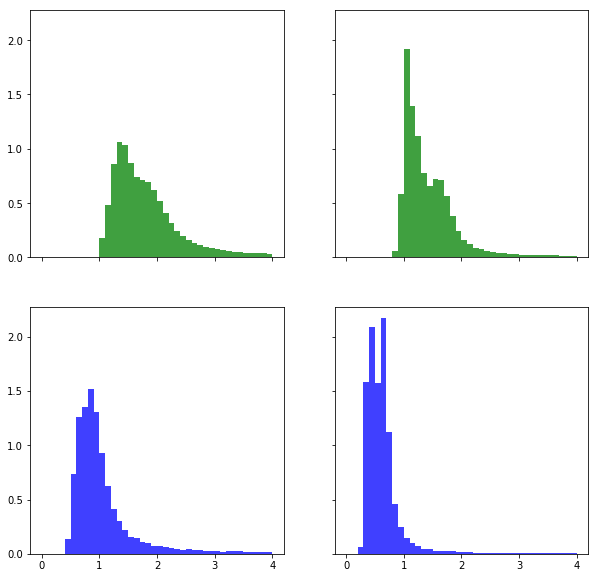

In [36]:
# Plot total histograms

sharded_reqs_mt = hist_data_sharded[2]
nonsharded_reqs_mt = hist_data_nonsharded[2]
xrng = [0, 4]
buckets = 40
num_subplots = len(hist_data_sharded)
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10,10))

axes[0,0].hist(sharded_reqs_mt['responsetime'], buckets, weights=sharded_reqs_mt['requests'], range=xrng, normed=1, facecolor='green', alpha=0.75)
axes[0,1].hist(nonsharded_reqs_mt['responsetime'], buckets, weights=nonsharded_reqs_mt['requests'], range=xrng, normed=1, facecolor='green', alpha=0.75)
axes[1,0].hist(sharded_reqs_mw['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.75)
axes[1,1].hist(nonsharded_reqs_mw['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.75)
plt.show()

In [ ]:
## Plotting response times on different middlewares
reps = range(1,4)

sharded_mw1 = gather_requests(exp_dir_shard, reps, ["middleware_04"])
sharded_mw2 = gather_requests(exp_dir_shard, reps, ["middleware_05"])

nonsharded_mw1 = gather_requests(exp_dir_nonshard, reps, ["middleware_04"])
nonsharded_mw2 = gather_requests(exp_dir_nonshard, reps, ["middleware_05"])

client_logfiles_mw1 = ["client_01_0.log", "client_02_0.log", "client_03_0.log"]
client_logfiles_mw2 = ["client_01_1.log", "client_02_1.log", "client_03_1.log"]
experiment = "sharded_6multiget"
reps = 3

filepaths_mw1 = [os.path.join(exp5_1_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles_mw1]
histograms = [np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths_mw1]
throughputs = [extract_GET_throughput(filepath) for filepath in filepaths_mw1]
histo_sharded_frommt_mw1 = calculate_responsetime_percentiles(histograms, throughputs, granularity)


filepaths_mw2 = [os.path.join(exp5_1_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles_mw2]
histograms = [np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths_mw2]
throughputs = [extract_GET_throughput(filepath) for filepath in filepaths_mw2]
histo_sharded_frommt_mw2 = calculate_responsetime_percentiles(histograms, throughputs, granularity)

experiment = "nonsharded_6multiget"
reps = 3

filepaths_mw1 = [os.path.join(exp5_2_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles_mw1]
histograms = [np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths_mw1]
throughputs = [extract_GET_throughput(filepath) for filepath in filepaths_mw1]
histo_nonsharded_frommt_mw1 = calculate_responsetime_percentiles(histograms, throughputs, granularity)


filepaths_mw2 = [os.path.join(exp5_2_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles_mw2]
histograms = [np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths_mw2]
throughputs = [extract_GET_throughput(filepath) for filepath in filepaths_mw2]
histo_nonsharded_frommt_mw2 = calculate_responsetime_percentiles(histograms, throughputs, granularity)

In [ ]:
## Plotting response times on different middlewares
xrng = [0, 4]
buckets = 100
num_subplots = len(hist_data_sharded)
fig, axes = plt.subplots(4, sharey=True, sharex=True, figsize=(10,16))

axes[0].hist(histo_sharded_frommt_mw1['responsetime'], buckets, weights=histo_sharded_frommt_mw1['requests'], range=xrng, normed=1, facecolor='green', alpha=0.5)
#axes[0].hist(histo_sharded_frommt_mw2['responsetime'], buckets, weights=histo_sharded_frommt_mw2['requests'], range=xrng, normed=1, facecolor='green', alpha=0.5)

axes[1].hist(histo_nonsharded_frommt_mw1['responsetime'], buckets, weights=histo_nonsharded_frommt_mw1['requests'], range=xrng, normed=1, facecolor='green', alpha=0.5)
#axes[1].hist(histo_nonsharded_frommt_mw2['responsetime'], buckets, weights=histo_nonsharded_frommt_mw2['requests'], range=xrng, normed=1, facecolor='green', alpha=0.5)

axes[2].hist(sharded_mw1['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.5)
#axes[2].hist(sharded_mw2['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.5)

axes[3].hist(nonsharded_mw1['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.5)
#axes[3].hist(nonsharded_mw2['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
filepath = os.path.join("/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/1", "client_02_0.log")
hist = extract_GET_histogram(filepath)
xput = extract_GET_throughput(filepath)
hist_array = np.array(hist, dtype=float)
interpolated = interpolate_histogram(hist_array, granularity)
with_numrequests = calculate_numrequests(np.vstack(interpolated).transpose(), xput, granularity)
with_numrequests

xrng = [0, 4]
buckets = 40
fig, ax = plt.subplots()
ax.hist(with_numrequests['responsetime'], buckets, weights=with_numrequests['requests'], range=xrng, normed=1, facecolor='green', alpha=0.75)
plt.show()

In [61]:
## EXP 5.1 Sharded. Why is Resp time for 6multiget slower than 9? Why is 9 Multiget faster than 6?
dirpaths = [os.path.join(exp5_1_dir, "sharded_{}multiget".format(multiget)) for multiget in [1,3,6,9]]
reps = range(1,4)
middlewares = ["middleware_04", "middleware_05"]

reqs_combined = [gather_requests(dir, reps, middlewares) for dir in dirpaths]
reqs_mw1 = [gather_requests(dir, reps, ["middleware_04"]) for dir in dirpaths]
reqs_mw2 = [gather_requests(dir, reps, ["middleware_05"]) for dir in dirpaths]

Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_1multiget/1/middleware_04/2017-11-24 090041
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_1multiget/1/middleware_05/2017-11-24 090042
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_1multiget/2/middleware_04/2017-11-24 090751
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_1multiget/2/middleware_05/2017-11-24 090751
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_1multiget/3/middleware_04/2017-11-24 091458
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085

Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_9multiget/3/middleware_05/2017-11-24 092019


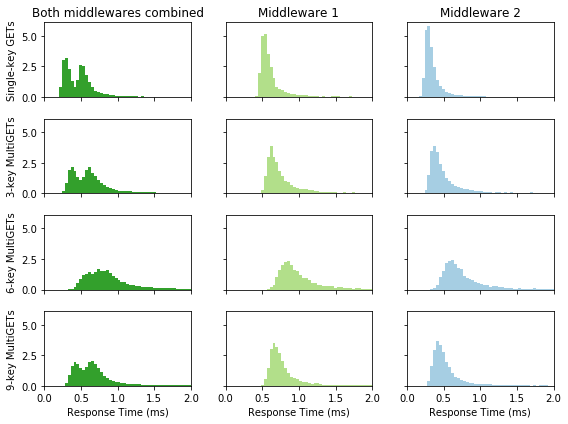

In [116]:
## EXP 5.1 Sharded. Why is Resp time for 6multiget slower than 9? Why is 9 Multiget faster than 6?
xrng = [0, 4]
buckets = 100
multigets = [1,3,6,9]
metricname = 'memcachedRTT_ms'
fig, axes = plt.subplots(4,3, sharey=True, sharex=True, figsize=(8,6))
axes[0,0].set_xlim([0,2])
for i in range(0,4):
    axes[i,0].hist(reqs_combined[i][metricname], buckets, range=xrng, normed=1, facecolor='#33a02c')
    axes[i,1].hist(reqs_mw1[i][metricname], buckets, range=xrng, normed=1, facecolor='#b2df8a')
    axes[i,2].hist(reqs_mw2[i][metricname], buckets, range=xrng, normed=1, facecolor='#a6cee3')
    
axes[0,0].set_title("Both middlewares combined")
axes[0,1].set_title("Middleware 1")
axes[0,2].set_title("Middleware 2")
axes[3,0].set_xlabel("Response Time (ms)")
axes[3,1].set_xlabel("Response Time (ms)")
axes[3,2].set_xlabel("Response Time (ms)")

axes[0,0].set_ylabel("Single-key GETs")
axes[1,0].set_ylabel("3-key MultiGETs")
axes[2,0].set_ylabel("6-key MultiGETs")
axes[3,0].set_ylabel("9-key MultiGETs")

plt.xticks([0,0.5,1,1.5,2])
plt.tight_layout()
plt.show()
fig.savefig("./graphs/exp5/memcachedRTT_histograms.png", dpi=300)

Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_1multiget/1/middleware_04/2017-11-24 090041
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_1multiget/1/middleware_05/2017-11-24 090042
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_3multiget/1/middleware_04/2017-11-24 090230
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_3multiget/1/middleware_05/2017-11-24 090231
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/1/middleware_04/2017-11-24 090417
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085

Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_9multiget/3/middleware_05/2017-11-24 092019


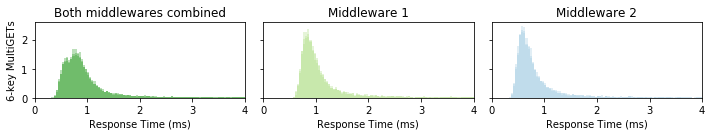

In [134]:
## EXP 5.1 Sharded. Why is Resp time for 6multiget slower than 9? Why is 9 Multiget faster than 6?
dirpaths = [os.path.join(exp5_1_dir, "sharded_{}multiget".format(multiget)) for multiget in [1,3,6,9]]
reps = [1]
middlewares = ["middleware_04", "middleware_05"]


xrng = [0, 4]
buckets = 100
columnname = 'memcachedRTT_ms'
fig, axes = plt.subplots(1,3, sharey=True, sharex=True, figsize=(10,2))
axes[0].set_xlim([0,4])
for rep in range(1,4):
    reqs_combined = [gather_requests(dir, [rep], middlewares) for dir in dirpaths]
    reqs_mw1 = [gather_requests(dir, [rep], ["middleware_04"]) for dir in dirpaths]
    reqs_mw2 = [gather_requests(dir, [rep], ["middleware_05"]) for dir in dirpaths]
    
    
    i=2
    axes[0].hist(reqs_combined[i][columnname], buckets, range=xrng, normed=1, facecolor='#33a02c', alpha=0.33)
    axes[1].hist(reqs_mw1[i][columnname], buckets, range=xrng, normed=1, facecolor='#b2df8a', alpha=0.33)
    axes[2].hist(reqs_mw2[i][columnname], buckets, range=xrng, normed=1, facecolor='#a6cee3', alpha=0.33)

axes[0].set_title("Both middlewares combined")
axes[1].set_title("Middleware 1")
axes[2].set_title("Middleware 2")
axes[0].set_xlabel("Response Time (ms)")
axes[1].set_xlabel("Response Time (ms)")
axes[2].set_xlabel("Response Time (ms)")
axes[0].set_ylabel("6-key MultiGETs")
plt.tight_layout()
plt.show()
fig.savefig(os.path.join("./graphs/exp5/", "sharded_6multiget_mw_histogram.png"), dpi=300)

Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_sharded_small_re-run_2017-12-05_193553/sharded_6multiget/1/middleware_04/2017-12-05 193718
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_sharded_small_re-run_2017-12-05_193553/sharded_6multiget/1/middleware_05/2017-12-05 193719
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_sharded_small_re-run_2017-12-05_193553/sharded_6multiget/2/middleware_04/2017-12-05 194052
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_sharded_small_re-run_2017-12-05_193553/sharded_6multiget/2/middleware_05/2017-12-05 194053
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_sharded_small_re-run_2017-12-05_193553/sharded_6multiget/3/middleware_04/2017-12-05 194425
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_sharded_small_re-

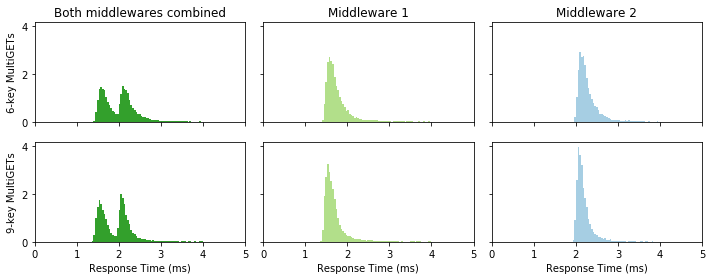

In [137]:
## EXP 5.1 Re-run Sharded to check 6-multiget anomaly
dirpaths = [os.path.join("/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_sharded_small_re-run_2017-12-05_193553", "sharded_{}multiget".format(multiget)) for multiget in [6,9]]
reps = range(1,4)
middlewares = ["middleware_04", "middleware_05"]

reqs_combined = [gather_requests(dir, reps, middlewares) for dir in dirpaths]
reqs_mw1 = [gather_requests(dir, reps, ["middleware_04"]) for dir in dirpaths]
reqs_mw2 = [gather_requests(dir, reps, ["middleware_05"]) for dir in dirpaths]
xrng = [0, 4]
buckets = 100
multigets = [6,9]
metricname = 'memcachedRTT_ms'
fig, axes = plt.subplots(2,3, sharey=True, sharex=True, figsize=(10,4))
axes[0,0].set_xlim([0,5])
for i in range(0,2):
    axes[i,0].hist(reqs_combined[i][metricname], buckets, range=xrng, normed=1, facecolor='#33a02c')
    axes[i,1].hist(reqs_mw1[i][metricname], buckets, range=xrng, normed=1, facecolor='#b2df8a')
    axes[i,2].hist(reqs_mw2[i][metricname], buckets, range=xrng, normed=1, facecolor='#a6cee3')

axes[0,0].set_title("Both middlewares combined")
axes[0,1].set_title("Middleware 1")
axes[0,2].set_title("Middleware 2")
axes[1,0].set_xlabel("Response Time (ms)")
axes[1,1].set_xlabel("Response Time (ms)")
axes[1,2].set_xlabel("Response Time (ms)")

axes[0,0].set_ylabel("6-key MultiGETs")
axes[1,0].set_ylabel("9-key MultiGETs")
plt.xticks([0,1.0,2.0,3.0,4.0,5.0])
plt.tight_layout()
plt.show()
fig.savefig("./graphs/exp5/memcachedRTT_histograms_rerun.png", dpi=300)